In [1]:
import xml.etree.ElementTree as ET
import os
from typing import List
from functools import reduce
from calendar import monthrange
import random
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
import time

## Gender-neutral adjectives describing people

In [184]:
from bs4 import BeautifulSoup
import urllib.request as urllib2
import csv

In [178]:
url = 'https://www.enchantedlearning.com/wordlist/adjectivesforpeople.shtml'
file = urllib2.urlopen(url)
html = file.read()
file.close()
soup = BeautifulSoup(html)

In [185]:
adj = soup.find_all(attrs={"class": "wordlist-item"})

In [188]:
adjs = [x.contents[0] for x in adj]

In [189]:
adjs[:5]

['able', 'abnormal', 'above average', 'absent-minded', 'adventurous']

In [195]:
with open('adjectives.csv', mode='w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(adjs)

In [205]:
with open('adjectives.csv') as csv_file:
    adjectives = csv_file.read().split(",")

# Data Parsing and Processing

In [3]:
class Doc:
    def __init__(self, id: int, gdescriptors: List[str], descriptors: List[str], text: str) -> None:
        self.id = id
        self.gdescriptors = gdescriptors
        self.descriptors = descriptors
        self.text = text

In [4]:
def parse_doc(file: str) -> Doc:
    tree = ET.parse(file)
    root = tree.getroot()
    try:
        fulltext = root.find('body').find('body.content').find("*[@class='full_text']")
        text = reduce(lambda x, y: x + y, [x.text for x in fulltext.findall('p')])
        id = int(root.find('head').find('docdata').find('doc-id').attrib['id-string'])
        classifiers = root.find('head').find('docdata').find('identified-content')
        gclassifiers = classifiers.findall("*[@class='online_producer'][@type='general_descriptor']")
        dclassifiers = classifiers.findall("*[@class='online_producer'][@type='descriptor']")
        gdescriptors = [c.text for c in gclassifiers]
        descriptors = [c.text for c in dclassifiers]
        return Doc(id, gdescriptors, descriptors, text)
    except:
        return None

In [5]:
def get_docs_by_month(year: int, month: int) -> List[Doc]:
    days = monthrange(year, month)[1]
    docs = []
    for day in range(1, days+1):
        for file in os.listdir(f'data/{year}/{month:02}/{day:02}/'):
            doc = parse_doc(f'data/{year}/{month:02}/{day:02}/{file}')
            if doc:
                docs.append(doc)
    return docs

In [6]:
t = time.process_time()
all_ = []
for y in range(1988, 2007):
    print(y)
    for i in range(1,13):
        all_ += get_docs_by_month(y, i)
time.process_time() - t

1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006


1028.6740360000001

In [7]:
len(all_)

1685787

# Saving files locally and loading

In [8]:
with open('alldocs.json', 'w') as outfile:
    json.dump([x.__dict__ for x in all_], outfile)

In [9]:
def save(i, arr):
    t = time.process_time()
    with open('alldocs' + str(i) + '.json', 'w') as outfile:
        json.dump([x.__dict__ for x in arr], outfile)
    print(time.process_time() - t)

In [10]:
def load(i):
    t = time.process_time()
    with open('alldocs' + str(i) + '.json', 'r') as infile:
        l = json.load(infile)
    print(time.process_time() - t)
    return l

In [11]:
save(0, all_[:600000])

26.122622999999976


In [12]:
l0 = load(0)

89.333306


In [13]:
save(1, all_[600000:1200000])

34.060252999999875


In [14]:
l1 = load(1)

102.26382799999988


In [15]:
save(2, all_[1200000:])

31.626627999999982


In [16]:
l2 = load(2)

19.019525000000158


In [17]:
l = l0 + l1 + l2
len(l)

1685787

In [18]:
t = time.process_time()
all06 = []
for i in range(1,13):
    all06 += get_docs_by_month(2006, i)
time.process_time() - t

45.86330799999996

In [19]:
len(all06)

85534

# Process by descriptor

In [20]:
t = time.process_time()
alld06 = {}
for doc in all06:
    for d in doc.descriptors:
        count, docs = alld06.get(d, (0, set()))
        docs.add(doc)
        alld06[d] = (count + 1, docs)
time.process_time() - t

0.19854899999995723

In [21]:
t = time.process_time()
alld = {}
for doc in l:
    doc = Doc(doc['id'], doc['gdescriptors'], doc['descriptors'], doc['text'])
    for d in doc.descriptors:
        count, docs = alld.get(d, (0, set()))
        docs.add(doc)
        alld[d] = (count + 1, docs)
time.process_time() - t

127.62715200000002

In [22]:
alldlist06 = sorted([(d, alld06[d][0], alld06[d][1]) for d in alld06], key=lambda x: x[1], reverse=True)
for x in range(10):
    print(alldlist06[x][0:2])

('Books and Literature', 1980)
('Politics and Government', 1715)
('Computers and the Internet', 1528)
('United States Politics and Government', 1374)
('Motion Pictures', 1360)
('Travel and Vacations', 1291)
('Baseball', 1263)
('Television', 1124)
('Terrorism', 1033)
('Deaths (Obituaries)', 988)


In [23]:
alldlist = sorted([(d, alld[d][0], alld[d][1]) for d in alld], key=lambda x: x[1], reverse=True)
for x in range(15):
    print(alldlist[x][0:2])

('Terrorism', 12393)
('Books and Literature', 11222)
('Politics and Government', 10589)
('Baseball', 9039)
('United States Politics and Government', 8295)
('Motion Pictures', 7748)
('Music', 7317)
('Weddings and Engagements', 7280)
('Medicine and Health', 6829)
('Travel and Vacations', 6537)
('Deaths (Obituaries)', 6438)
('Television', 6171)
('Football', 6070)
('Computers and the Internet', 5952)
('Basketball', 5746)


In [104]:
computers = list(filter(lambda x: 'Politics and Government' not in x.descriptors, \
                        alld['Computers and the Internet'][1]))

In [25]:
def inrange(c, lo, hi):
    return len(c.text.split(" ")) >= lo and len(c.text.split(" ")) <= hi

In [26]:
computersr = [c for c in computers if inrange(c, 500, 1500)]

In [27]:
len(computersr)

1061

In [28]:
len(computers)

1503

In [29]:
lens = []
for c in computers:
    lens.append(len(c.text.split(" ")))

In [30]:
np.mean(lens), np.median(lens), np.max(lens), np.min(lens)

(948.2388556220892, 892.0, 8290, 87)

(array([766., 664.,  51.,  10.,   3.,   2.,   2.,   1.,   1.,   3.]),
 array([  87. ,  907.3, 1727.6, 2547.9, 3368.2, 4188.5, 5008.8, 5829.1,
        6649.4, 7469.7, 8290. ]),
 <a list of 10 Patch objects>)

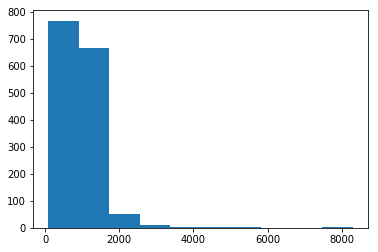

In [31]:
plt.hist(lens)

In [99]:
mps = list(filter(lambda x: 'Politics and Government' not in x.descriptors, \
                        alld['Motion Pictures'][1]))

In [100]:
books = list(filter(lambda x: 'Politics and Government' not in x.descriptors, \
                        alld['Books and Literature'][1]))

In [102]:
sports = list(filter(lambda x: 'Politics and Government' not in x.descriptors, \
                        alld['Football'][1]|alld['Baseball'][1]|alld['Basketball'][1]))

In [105]:
len(mps), len(books), len(sports), len(computers)

(7687, 10812, 20637, 5825)

# Politics: all

In [32]:
politics = list(filter(lambda x: 'Computers and the Internet' not in x.descriptors, \
                        alld['Politics and Government'][1]))

In [34]:
lens2 = []
for c in politics:
    lens2.append(len(c.text.split(" ")))

In [35]:
np.mean(lens2), np.median(lens2), np.max(lens2), np.min(lens2)

(910.1887359441644, 819.5, 10083, 27)

(array([7.257e+03, 2.827e+03, 1.320e+02, 4.000e+01, 2.700e+01, 1.200e+01,
        1.000e+00, 1.100e+01, 6.000e+00, 3.000e+00]),
 array([   27. ,  1032.6,  2038.2,  3043.8,  4049.4,  5055. ,  6060.6,
         7066.2,  8071.8,  9077.4, 10083. ]),
 <a list of 10 Patch objects>)

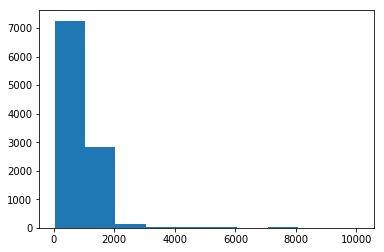

In [36]:
plt.hist(lens2)

In [37]:
computerss = random.sample(computers, 1500)

In [38]:
politicsr = [p for p in politics if inrange(p, 500, 1500)]

In [39]:
len(politicsr)

7967

In [40]:
len(politics)

10316

In [41]:
politicss = random.sample(politics, 1500)

In [42]:
politics[0].text

"George W. Bush's promise to end ''the soft bigotry of low expectations'' that permits minority children to fall permanently behind at school seemed destined to go nowhere after Sept. 11. Even before then, the House and Senate appeared hopelessly tied up in bickering over the federal government's proper role in aiding local schools. But now  the leaders of both parties have quietly reached tentative agreement on a ground-breaking bill that  holds the states accountable as never before for rescuing failing schools and closing the achievement gap between rich and poor students. The only danger is that the federal government will deluge the schools with new mandates while providing too little money to get the job done.The most valuable part of the plan is a requirement that the states conduct annual testing in reading and math for students in grades three through eight. These tests would allow parents to learn how their children's schools stack up against others in the state, and how they

# Training Word Embeddings

In [45]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [268]:
simple_preprocess(politics[10].text)[:10] # lowercasing, de-punctuation

['the',
 'bush',
 'administration',
 'may',
 'soon',
 'disclose',
 'secret',
 'details',
 'of',
 'the']

In [47]:
len(politics)

10316

In [281]:
def getw2v(category):
    docs = [simple_preprocess(t.text) for t in category]
    return Word2Vec(docs)

In [236]:
def getw2v(category, s):
    docs = [simple_preprocess(t.text) for t in category]
    return Word2Vec(docs, size=s)   

In [237]:
t = time.process_time()
mpol3 = getw2v(politics, 300)
time.process_time() - t

158.2856069999998

In [242]:
t = time.process_time()
mmps3 = getw2v(mps, 300)
time.process_time() - t

130.69884300000012

In [243]:
t = time.process_time()
msports3 = getw2v(sports, 300)
time.process_time() - t

264.18480999999974

In [244]:
t = time.process_time()
mbooks3 = getw2v(books, 300)
time.process_time() - t

187.28347900000063

In [245]:
t = time.process_time()
mcomp3 = getw2v(computers, 300)
time.process_time() - t

91.44286399999964

In [276]:
t = time.process_time()
m_pol = getw2v(politics)
time.process_time() - t

487.4492489999993

In [115]:
t = time.process_time()
m_mps, sg_mps = getw2v(mps)
time.process_time() - t

350.08934

In [116]:
t = time.process_time()
m_books, sg_books = getw2v(books)
time.process_time() - t

522.6720100000002

In [137]:
t = time.process_time()
m_sports, sg_sports = getw2v(sports)
time.process_time() - t

697.0087489999996

In [277]:
m_pol.wv.most_similar(positive=['good'], topn=5)

[('bad', 0.7701998353004456),
 ('great', 0.5736860036849976),
 ('simple', 0.5706285238265991),
 ('big', 0.5503104329109192),
 ('healthy', 0.5360066890716553)]

In [120]:
sg_books.wv.most_similar(positive=['good'], topn=5)

[('bad', 0.8037024736404419),
 ('nice', 0.7105066776275635),
 ('darn', 0.6723470687866211),
 ('hoot', 0.6688886880874634),
 ('underwrites', 0.6674895882606506)]

In [111]:
m_mps.wv.most_similar(positive=['thursday'], topn=5)

[('wednesday', 0.9533427953720093),
 ('monday', 0.949042558670044),
 ('tuesday', 0.9402897357940674),
 ('feb', 0.9159979820251465),
 ('nov', 0.8782657384872437)]

In [118]:
sg_mps.wv.most_similar(positive=['thursday'], topn=5)

[('wednesday', 0.8984960317611694),
 ('tuesday', 0.8942105770111084),
 ('monday', 0.8819349408149719),
 ('sunday', 0.81260085105896),
 ('saturday', 0.8052012324333191)]

In [48]:
t = time.process_time()
docs = [simple_preprocess(t.text) for t in politics]
time.process_time() - t

13.110403000000133

In [49]:
t = time.process_time()
model = Word2Vec(docs)
time.process_time() - t

89.455289

In [50]:
t = time.process_time()
sg = Word2Vec(docs,sg=1)
time.process_time() - t

287.23453400000017

In [51]:
model.wv.most_similar(positive=['thursday'], topn=5)

[('wednesday', 0.966515302658081),
 ('tuesday', 0.9625621438026428),
 ('monday', 0.9531980156898499),
 ('friday', 0.9439132213592529),
 ('sunday', 0.9063440561294556)]

In [122]:
model.wv.most_similar(positive=['approve'], topn=5)

[('submit', 0.8420201539993286),
 ('enact', 0.8022587299346924),
 ('amend', 0.8013858199119568),
 ('override', 0.7858759760856628),
 ('propose', 0.7809127569198608)]

In [53]:
sg.wv.most_similar(positive=['approve'], topn=5)

[('amend', 0.7634615898132324),
 ('approved', 0.7592514753341675),
 ('resubmit', 0.7551741600036621),
 ('submit', 0.7530202865600586),
 ('authorize', 0.7511330842971802)]

In [54]:
model.wv.most_similar(positive=['republican'], topn=10)

[('democratic', 0.7588052749633789),
 ('democrat', 0.7039002180099487),
 ('republicans', 0.6108230352401733),
 ('ohio', 0.599784791469574),
 ('montana', 0.5995473861694336),
 ('wisconsin', 0.5822083353996277),
 ('democrats', 0.5816711783409119),
 ('missouri', 0.5749313831329346),
 ('nevada', 0.5689836144447327),
 ('texas', 0.5451416969299316)]

In [55]:
sg.wv.most_similar(positive=['republican'], topn=10)

[('mitch', 0.7215871810913086),
 ('dewine', 0.7157849669456482),
 ('democratic', 0.712923526763916),
 ('republicans', 0.6989976167678833),
 ('schluter', 0.6967225074768066),
 ('serphin', 0.695811927318573),
 ('kemp', 0.6898654699325562),
 ('democrats', 0.6840780377388),
 ('pawlenty', 0.6832119822502136),
 ('haytaian', 0.6783065795898438)]

In [56]:
model.wv.most_similar(positive=['democrat'], topn=10)

[('montana', 0.7756986618041992),
 ('wisconsin', 0.735527753829956),
 ('illinois', 0.7299346923828125),
 ('vermont', 0.707344651222229),
 ('republican', 0.7039002180099487),
 ('maryland', 0.7038766145706177),
 ('indiana', 0.6947270631790161),
 ('massachusetts', 0.6933934092521667),
 ('nebraska', 0.6932546496391296),
 ('assemblyman', 0.6813335418701172)]

In [57]:
sg.wv.most_similar(positive=['democrat'], topn=10)

[('montana', 0.7596157193183899),
 ('serphin', 0.7321606874465942),
 ('nita', 0.7243488430976868),
 ('cleland', 0.7215176224708557),
 ('dingell', 0.719240665435791),
 ('senator', 0.7189056277275085),
 ('hannon', 0.7154656648635864),
 ('rep', 0.715215265750885),
 ('hoyer', 0.7151182293891907),
 ('padavan', 0.7111424803733826)]

In [58]:
model.wv.get_vector('democrat').shape

(100,)

# Summarization

In [59]:
from gensim.summarization.summarizer import summarize
from gensim.models import LsiModel
from gensim.test.utils import common_dictionary, common_corpus

In [60]:
politics[10].text

"The Bush administration may soon disclose secret details of the relationship between the Central Intelligence Agency and Peru's powerful former spy chief, Vladimiro L. Montesinos, Peru's president said in an interview yesterday in New York.President Alejandro Toledo of Peru said he had requested the release of the documents because Mr. Montesinos remained a threat to Peru's fledgling democracy. He accused Mr. Montesinos of using extortion and bribery from his Peruvian jail cell to exert sweeping political influence in Peru. Mr. Montesinos is awaiting trial on charges of money laundering and drug dealing during the decade he was a major adviser and political operative of former President Alberto K. Fujimori.Mr. Toledo, who took office in July, vowed to continue his efforts to dismantle the network of corruption and violence that he inherited.. ''We are stepping on people's toes,'' said Mr. Toledo, 55. The corrupt activities of which Mr. Montesinos and others are accused generated milli

In [61]:
summarize(politics[10].text, word_count=200)

"The Bush administration may soon disclose secret details of the relationship between the Central Intelligence Agency and Peru's powerful former spy chief, Vladimiro L.\nHe accused Mr. Montesinos of using extortion and bribery from his Peruvian jail cell to exert sweeping political influence in Peru.\nMr. Montesinos is awaiting trial on charges of money laundering and drug dealing during the decade he was a major adviser and political operative of former President Alberto K.\nFujimori.Mr. Toledo, who took office in July, vowed to continue his efforts to dismantle the network of corruption and violence that he inherited..\nThe corrupt activities of which Mr. Montesinos and others are accused generated millions of dollars in secret payments.\nAlthough the accounts holding much of that money were frozen when Mr. Montesinos was arrested in June, authorities say he has replenished his accounts by threatening to release damaging information on public officials unless they pay him.Mr. Toledo 

In [62]:
s = summarize(politics[10].text)
len(s.split(" "))

58

In [64]:
print(s)

Although the accounts holding much of that money were frozen when Mr. Montesinos was arrested in June, authorities say he has replenished his accounts by threatening to release damaging information on public officials unless they pay him.Mr. Toledo said he asked for the documents on Mr. Montesinos and his links to American intelligence soon after he took office.


In [79]:
t = time.process_time()
# summaries_pol = [summarize(x.text) for x in politics if len(x.text) > 500]
summaries_pol = []
for i in range(len(politics)):
    try:
        summaries_pol.append(summarize(politics[i].text))
    except:
        x = politics[i]
        print(i)
time.process_time() - t

1646
2145
2331
5396
5569
6193
8035
8425


153.342576

In [261]:
t = time.process_time()
summaries_comp = []
for i in range(len(computers)):
    try:
        summaries_comp.append(summarize(computers[i].text))
    except:
        print(i)
time.process_time() - t

1177
1446
1726
3299
3741
5160
5280


104.35523600000033

In [262]:
t = time.process_time()
summaries_books = []
for i in range(len(books)):
    try:
        summaries_books.append(summarize(books[i].text))
    except:
        print(i)
time.process_time() - t

5041
5715
7698
10366


197.67950399999972

In [263]:
t = time.process_time()
summaries_mps = []
for i in range(len(mps)):
    try:
        summaries_mps.append(summarize(mps[i].text))
    except:
        print(i)
time.process_time() - t

1054
6061
7134


150.2760619999999

In [264]:
t = time.process_time()
summaries_sports = []
for i in range(len(sports)):
    try:
        summaries_sports.append(summarize(sports[i].text))
    except:
        print(i)
time.process_time() - t

5609
7095
7489
9951
14430
15885
16586
17220


300.2605589999994

In [74]:
len(politics)

10316

In [80]:
len(summaries_pol)

10308

In [78]:
politics[1646].text

"Hopes of a breakthrough in the deadlocked Northern Ireland peace process were dashed today when Prime Ministers Tony Blair of Britain and Bertie Ahern of Ireland had to cancel a joint appearance here because of last-minute objections by Sinn Fein, the political party of the Irish Republican Army.The two leaders had planned to announce a final plan for reviving the suspended power-sharing government in Northern Ireland.The new plan, drawn up in London and Dublin, was aimed at producing a long-awaited decision by the I.R.A. to disarm and renounce violence for good.But a Downing Street spokesman announced today that Mr. Blair and Mr. Ahern were abandoning their trip here.Continuing discussions between the governments and the party leaders had persuaded the two leaders that ''sufficient progress has not yet been made'' to let the meeting go ahead, he said.They would meet together this evening in London instead ''to pause, reflect and take stock,'' the spokesman added."

In [282]:
def getw2v_s(sums):
    docs = [simple_preprocess(t) for t in sums]
    return Word2Vec(docs)

# Measuring Bias

In [81]:
with open('debiaswe-master/data/equalize_pairs.json') as f:
    pairs = json.loads(f.read())

In [82]:
from sklearn.decomposition import PCA
from matplotlib.pyplot import bar

In [83]:
pairs = list(map(lambda x: [x[0].lower(), x[1].lower()], pairs))

In [136]:
pairs

[['monastery', 'convent'],
 ['spokesman', 'spokeswoman'],
 ['catholic_priest', 'nun'],
 ['dad', 'mom'],
 ['men', 'women'],
 ['councilman', 'councilwoman'],
 ['grandpa', 'grandma'],
 ['grandsons', 'granddaughters'],
 ['prostate_cancer', 'ovarian_cancer'],
 ['testosterone', 'estrogen'],
 ['uncle', 'aunt'],
 ['wives', 'husbands'],
 ['father', 'mother'],
 ['grandpa', 'grandma'],
 ['he', 'she'],
 ['boy', 'girl'],
 ['boys', 'girls'],
 ['brother', 'sister'],
 ['brothers', 'sisters'],
 ['businessman', 'businesswoman'],
 ['chairman', 'chairwoman'],
 ['colt', 'filly'],
 ['congressman', 'congresswoman'],
 ['dad', 'mom'],
 ['dads', 'moms'],
 ['dudes', 'gals'],
 ['ex_girlfriend', 'ex_boyfriend'],
 ['father', 'mother'],
 ['fatherhood', 'motherhood'],
 ['fathers', 'mothers'],
 ['fella', 'granny'],
 ['fraternity', 'sorority'],
 ['gelding', 'mare'],
 ['gentleman', 'lady'],
 ['gentlemen', 'ladies'],
 ['grandfather', 'grandmother'],
 ['grandson', 'granddaughter'],
 ['he', 'she'],
 ['himself', 'herself'],

## For Politics

In [125]:
def getg(m):
    matrix = []
    for a, b in pairs:
        if a not in m.wv.vocab or b not in m.wv.vocab:
            continue
        center = (m.wv.get_vector(a) + m.wv.get_vector(b))/2
        matrix.append(m.wv.get_vector(a) - center)
        matrix.append(m.wv.get_vector(b) - center)
    matrix = np.array(matrix)
    p = PCA(n_components = 10)
    p.fit(matrix)
    bar(range(10), p.explained_variance_ratio_)
    print(matrix.shape)
    return p.components_[0]

(76, 100)


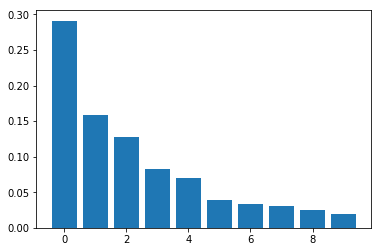

In [278]:
g_pol2 = getg(m_pol)

(90, 100)


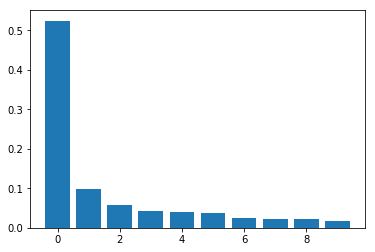

In [126]:
g_mps = getg(m_mps)

(90, 100)


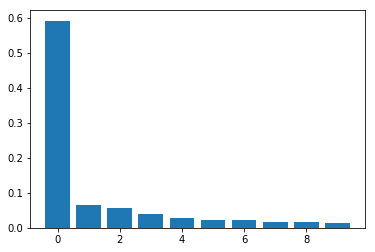

In [127]:
g_books = getg(m_books)

(80, 100)


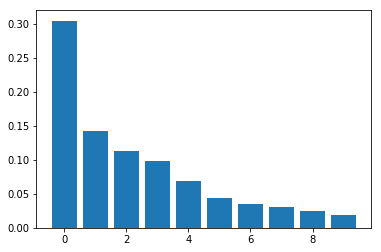

In [138]:
g_sports = getg(m_sports)

(76, 100)


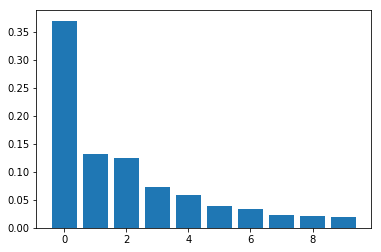

In [85]:
# borrowed from Bolukbasi et al
matrix = []
for a, b in pairs:
    if a not in model.wv.vocab or b not in model.wv.vocab:
        continue
    center = (model.wv.get_vector(a) + model.wv.get_vector(b))/2
    matrix.append(model.wv.get_vector(a) - center)
    matrix.append(model.wv.get_vector(b) - center)
matrix = np.array(matrix)
pca = PCA(n_components = 10)
pca.fit(matrix)
bar(range(10), pca.explained_variance_ratio_)
print(matrix.shape)

<BarContainer object of 10 artists>

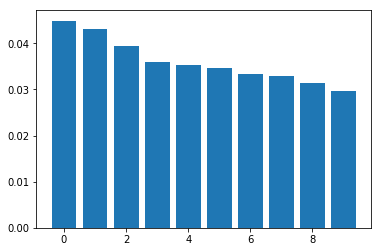

In [96]:
pca_r = PCA(n_components = 10)
pca_r.fit(np.random.rand(76,100))
bar(range(10), pca_r.explained_variance_ratio_)

In [87]:
pca.components_[0].shape

(100,)

In [88]:
g = pca.components_[0]

In [131]:
def gproj(g, m, w1):
    wvec = m.wv.get_vector(w1)
    p = np.dot(g, wvec)/np.linalg.norm(g)
    return p

In [90]:
wordlist = ['he', 'she', 'doctor', 'nurse', 'man', 'woman', 'male', 'female', 'politician', 'guy', \
            'scientist', 'teacher', 'professor', 'mother', 'pretty', 'handsome', 'strong', 'coward', \
            'dress', 'timid', 'leadership', 'blond', 'lovely', 'petite', 'surgeon', 'physician', 'shopkeeper', \
            'cooking', 'sewing', 'chuckle', 'sassy', 'lanky', 'competent', 'brilliant', 'capable', 'smart', \
            'intelligent', 'incompetent', 'librarian', 'cosmetics', 'maid', 'clever', 'dressed', 'captain', \
            'nanny', 'philosopher', 'architect', 'financier', 'warrior', 'magician', 'housekeeper', 'homemaker']

In [91]:
len(wordlist)

52

In [296]:
for x in filter(lambda x: x in m_pol_s.wv.vocab, wordlist):
    print(x, gproj(g_pol2, m_pol, x))

he 2.8105197
she -5.6459923
doctor -1.0489206
nurse -0.17620346
man 3.8891761
woman -2.8334298
male -1.2500108
female -2.1939878
politician 2.564194
guy 0.9539458
scientist 1.8408958
teacher -1.0036469
professor 2.4944913
mother -1.7913157
pretty -1.360877
handsome -0.025922855
strong 0.30098295
dress -0.87943053
timid -0.03581514
leadership 2.1501873
blond -0.472618
lovely -0.17515591
surgeon 0.45692998
physician 0.4484733
shopkeeper 0.36269495
cooking -0.100637555
lanky 0.14558364
competent -0.007338649
brilliant 0.31558698
capable 0.28279185
smart -0.29120904
intelligent -0.16850704
incompetent 0.13866481
librarian 0.015081462
cosmetics 0.027424363
maid -0.18722029
clever 0.057584934
dressed -0.4531575
captain 0.808699
nanny 0.114777714
philosopher 0.6383292
architect 1.6235939
financier 0.4208144
warrior 0.6456485
homemaker -0.07632408


In [294]:
for x in filter(lambda x: x in m_pol_s.wv.vocab, wordlist):
    print(x, gproj(gpol_s, m_pol_s, x))

he 3.630472
she -7.043937
doctor -0.5483555
nurse -0.101625055
man 0.6724119
woman -2.104624
male -0.7091877
female -0.73684615
politician 0.48999584
guy -0.20535713
scientist -0.09677285
teacher -0.42919195
professor -0.06367353
mother -1.2419612
pretty -0.653125
handsome -0.18689041
strong 0.33946192
dress -0.31632563
timid -0.049695645
leadership 2.0021334
blond -0.09693908
lovely -0.14093867
surgeon -0.017406816
physician -0.010592686
shopkeeper 0.0010680961
cooking -0.09819894
lanky 0.032721754
competent -0.10022683
brilliant 0.06563793
capable -0.09329388
smart -0.25878468
intelligent -0.35525897
incompetent 0.038933847
librarian -0.07244852
cosmetics 0.018950026
maid -0.11877883
clever 0.018979466
dressed -0.13837661
captain -0.012679186
nanny -0.02870044
philosopher 0.0056038024
architect 0.423599
financier -0.034385435
warrior -0.022099825
homemaker -0.15800034


In [132]:
for x in wordlist:
    print(x, gproj(g, model, x))

he 3.5649714
she -7.6814733
doctor -1.333911
nurse -0.5239806
man 3.1305177
woman -5.0117645
male -1.7998456
female -2.275268
politician 1.8248957
guy 0.7922988
scientist 1.4119161
teacher -1.0073268
professor 2.1761525
mother -2.4471753
pretty -1.1641369
handsome -0.21486638
strong -0.124037966
coward 0.11255191
dress -1.3112665
timid -0.21009919
leadership 2.4456248
blond -0.6415013
lovely -0.20070261
petite -0.10919192
surgeon 0.21892357
physician 0.15660925
shopkeeper 0.048395697
cooking -0.4303634
sewing -0.1652865
chuckle 0.13762662
sassy -0.107665226
lanky 0.07525485
competent -0.180032
brilliant 0.33673185
capable 0.2729264
smart -0.34357873
intelligent -0.7443394
incompetent 0.20247883
librarian -0.07387295
cosmetics 0.012417146
maid -0.41983935
clever 0.01827344
dressed -0.530751
captain 0.5767532
nanny -0.033859324
philosopher 0.26500937
architect 1.5979341
financier 0.313736
warrior 0.35137555
magician 0.03315904
housekeeper -0.10215095
homemaker -0.16961318


In [133]:
for x in wordlist:
    print(x, gproj(g_mps, m_mps, x))

he 2.771003
she -8.699276
doctor -0.56526935
nurse -1.8436737
man 4.0526066
woman -7.3986273
male -2.5096903
female -3.104202
politician -0.16850522
guy 2.243238
scientist -0.113046385
teacher -2.1887233
professor 0.18350281
mother -6.349626
pretty -2.2116635
handsome -0.9554814
strong -0.8502479
coward 0.013855044
dress -4.3068633
timid -0.18128367
leadership 0.36781493
blond -3.7995522
lovely -2.6187305
petite -0.7528529
surgeon -0.18204775
physician 0.054367438
shopkeeper -0.24016824
cooking -0.7464523
sewing -0.06684109
chuckle -0.07192879
sassy -0.6439013
lanky -0.06616593
competent -0.084814645
brilliant 0.34301803
capable -0.34147573
smart -0.88639826
intelligent -0.90993845
incompetent -0.14164056
librarian -0.045012202
cosmetics -0.1733421
maid -2.2596412
clever 0.25580758
dressed -1.7594016
captain 1.1048737
nanny -0.58874255
philosopher -0.07882123
architect 0.19345054
financier 0.27459878
warrior -0.39253327
magician -0.02187738
housekeeper -0.7618404
homemaker -0.1423586


In [134]:
for x in wordlist:
    print(x, gproj(g_books, m_books, x))

he 3.6996477
she -9.274354
doctor -0.7665047
nurse -1.6922721
man 3.2278986
woman -7.376057
male -3.3451371
female -4.0072956
politician 1.2179149
guy 1.1493855
scientist 1.528822
teacher -1.4437807
professor 1.4051809
mother -5.462462
pretty -2.157434
handsome -0.65407634
strong -0.2343367
coward 0.45657516
dress -3.3258433
timid -0.014244264
leadership 2.8841667
blond -2.1282415
lovely -2.4184675
petite -0.4474669
surgeon 0.35871372
physician 0.21884999
shopkeeper -0.09054132
cooking -2.2126558
sewing -0.18703403
chuckle -0.105727926
sassy -0.53844106
lanky 0.09455176
competent 0.043828595
brilliant 0.8316055
capable 0.21425995
smart -1.554529
intelligent -0.3188492
incompetent 0.086284064
librarian -0.42042577
cosmetics -0.17692275
maid -1.2714504
clever -0.5266647
dressed -1.7314423
captain 1.4062334
nanny -1.3808886
philosopher 1.6916357
architect 1.1166052
financier 0.44432104
warrior 0.50778127
magician 0.24222495
housekeeper -0.5344718
homemaker -0.27057874


In [224]:
m_comp, sg_comp = getw2v(computers)

(74, 100)


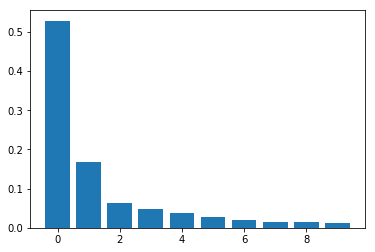

In [225]:
g_comp = getg(m_comp)

In [227]:
for x in filter(lambda x: x in m_comp.wv.vocab, wordlist):
    print(x, gproj(g_comp, m_comp, x))

he 4.1156554
she -9.497332
doctor -0.5660993
nurse -0.31186727
man 0.07067332
woman -2.517825
male -0.7569068
female -1.1827465
politician 0.09823007
guy 0.20402555
scientist 1.689536
teacher -0.44487903
professor 2.2498739
mother -1.9652002
pretty -0.10082699
handsome -0.10136598
strong 0.26259145
dress -0.8267326
timid 0.011710629
leadership 0.80019534
blond -0.37642366
lovely -0.1122925
petite 0.003749184
surgeon 0.20778573
physician 0.07985366
cooking -0.71526134
sewing -0.20431827
chuckle -0.07227164
lanky -0.026295677
competent -0.030422963
brilliant 0.57587606
capable -0.06260362
smart -0.56648976
intelligent 0.070581555
incompetent -0.0016804592
librarian -0.04549685
cosmetics -0.2874487
clever -0.30636162
dressed -0.8209281
captain 0.035569746
nanny -0.060233973
philosopher 0.11198886
architect 1.2152075
financier 0.08575766
warrior -0.04722012
magician -0.013950176
housekeeper 0.012270727
homemaker -0.03182672


(76, 300)


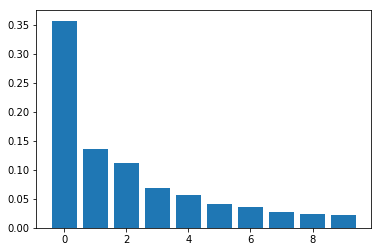

In [246]:
gpol3 = getg(mpol3)

(80, 300)


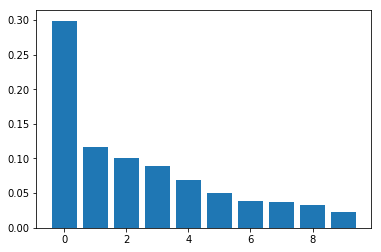

In [247]:
gsports3 = getg(msports3)

(74, 300)


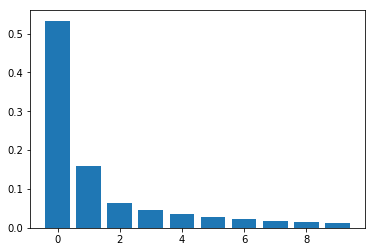

In [248]:
gcomp3 = getg(mcomp3)

(90, 300)


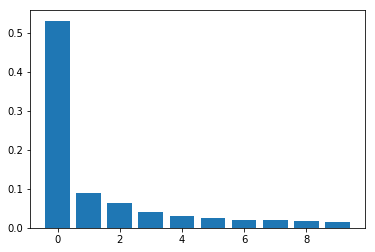

In [249]:
gbooks3 = getg(mbooks3)

(90, 300)


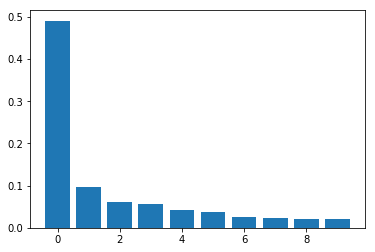

In [250]:
gmps3 = getg(mmps3)

In [283]:
m_pol_s = getw2v_s(summaries_pol)

In [ ]:
m_comp_s = getw2v_s(summaries_comp)

In [ ]:
m_books_s, sg_books_s = getw2v(summaries_books)

In [ ]:
m_sports_s, sg_sports_s = getw2v(summaries_sports)

In [ ]:
m_mps_s, sg_mps_s = getw2v(summaries_mps)

In [ ]:
gcomp_s = getg(m_comp_s)

In [ ]:
gbooks_s = getg(m_books_s)

In [ ]:
gsports_s = getg(m_sports_s)

In [ ]:
gmps_s = getg(m_mps_s)

(66, 100)


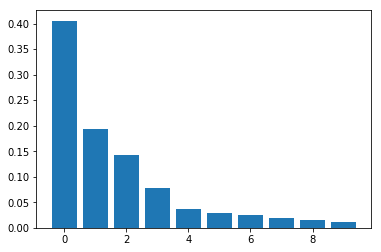

In [284]:
gpol_s = getg(m_pol_s)

## Bias measured on list of professions

In [140]:
with open('debiaswe-master/data/professions.json') as f:
    profs = json.loads(f.read())

In [142]:
proflist = list(filter(lambda x: x in model.wv.vocab, [p[0] for p in profs if abs(p[1]) < 0.6]))

In [143]:
len(proflist)

221

In [164]:
count = 0
for p in proflist:
    count += 1
    if count > 20:
        continue
    if p in m_sports.wv.vocab:
        print(p, gproj(g_sports, m_sports, p))

accountant -0.83289635
acquaintance -0.50980324
administrator -0.91552037
advocate -0.8800565
aide -0.76167756
ambassador -0.6983289
analyst -1.5815004
archbishop -0.73365533
architect -0.82800335
artist -0.98049676
assassin -0.2566313
astronaut -0.33753246
athlete -1.7739706
attorney -3.814591
author -3.061033
baker 1.9187592
banker -0.6870409
barber 3.3252947


In [211]:
def bias(g, m, wordlist):
    b = 0
    l = list(filter(lambda x: x in m.wv.vocab, wordlist))
    for x in l:
        b += gproj(g, m, x)**2
    return b/len(l)

In [230]:
def testbias(wordlist):
    print(f"sports: {bias(g_sports, m_sports, wordlist)}")
    print(f"politics: {bias(g, model, wordlist)}")
    print(f"motion pictures: {bias(g_mps, m_mps, wordlist)}")
    print(f"books: {bias(g_books, m_books, wordlist)}")
    print(f"computers: {bias(g_comp, m_comp, wordlist)}")

In [253]:
def testbias_s(wordlist):
    print(f"sports: {bias(gsports_s, msports_s, wordlist)}")
    print(f"politics: {bias(gpol_s, mpol_s, wordlist)}")
    print(f"motion pictures: {bias(gmps_s, mmps_s, wordlist)}")
    print(f"books: {bias(gbooks_s, mbooks_s, wordlist)}")
    print(f"computers: {bias(gcomp_s, mcomp_s, wordlist)}")

In [287]:
bias(gpol_s, m_pol_s, proflist)

0.3517503718193723

In [289]:
bias(gpol_s, m_pol_s, adjectives)

0.06198732174690184

In [292]:
bias(gpol_s, m_pol_s, gender_specific)

1.9493272681336744

In [231]:
testbias(proflist)

sports: 2.0857769698658295
politics: 0.8232615661450845
motion pictures: 0.5776207802681335
books: 0.6842213509103686
computers: 0.4213832395256096


In [232]:
testbias(gender_specific)

sports: 5.779429515260733
politics: 2.9005783247111094
motion pictures: 4.494571923607481
books: 4.897121935916791
computers: 2.7032083623704977


In [233]:
testbias(adjectives)

sports: 0.8146448604118944
politics: 0.1831534225112732
motion pictures: 0.3157271398898077
books: 0.25922013505394975
computers: 0.08504724018894734


In [235]:
testbias(gender_specific_full)

sports: 4.916862356584887
politics: 2.3594446882919202
motion pictures: 3.133462319764807
books: 3.310727659986112
computers: 2.2559530652093205


In [165]:
with open('debiaswe-master/data/gender_specific_seed.json') as f:
    gender_specific = json.loads(f.read())

In [166]:
len(gender_specific)

218

In [168]:
gender_specific[:10]

['actress',
 'actresses',
 'aunt',
 'aunts',
 'bachelor',
 'ballerina',
 'barbershop',
 'baritone',
 'beard',
 'beards']

In [234]:
with open('debiaswe-master/data/gender_specific_full.json') as f:
    gender_specific_full = json.loads(f.read())

In [ ]:
len(gender_specific_full)

In [ ]:
gender_specific[:10]

In [ ]:
gender_specific_full[:10]

In [141]:
profs[:5]

[['accountant', 0.0, 0.4],
 ['acquaintance', 0.0, 0.0],
 ['actor', 0.8, 0.0],
 ['actress', -1.0, 0.0],
 ['adjunct_professor', 0.0, 0.5]]

In [ ]:
# female - male vector

In [ ]:
gendervec = model.wv.get_vector('he') - model.wv.get_vector('she')

In [ ]:
mtest = model.wv.get_vector('woman') + model.wv.get_vector('he') - model.wv.get_vector('she')

In [ ]:
model.most_similar(positive=[mtest], topn=1)

In [ ]:
def get_proj(w1):
    gendervec = model.wv.get_vector('he') - model.wv.get_vector('she')
    wvec = model.wv.get_vector(w1)
    p = np.dot(gendervec, wvec)/np.linalg.norm(gendervec)
    return p

In [ ]:
get_proj('him'), get_proj('it'), get_proj('she'), get_proj('he')

In [ ]:
get_proj('her'), get_proj('female'), get_proj('male')

In [ ]:
get_proj('cat'), get_proj('hat'), get_proj('doctor'), get_proj('nurse')

In [ ]:
get_proj('woman'), get_proj('man'), get_proj('actor') 